**Panorama.py** : 

[[ 9.64887214e-01  2.67832092e-02 -6.87624441e+02]
 [-2.67832092e-02  9.64887214e-01  6.51774894e+01]]
[[ 1.14782913e+00 -1.17151856e-02 -8.24342884e+02]
 [ 5.47760614e-02  1.09969560e+00 -8.30613546e+01]
 [ 7.61737947e-05 -3.53625263e-08  1.00000000e+00]]
-842 -83 2016 1580


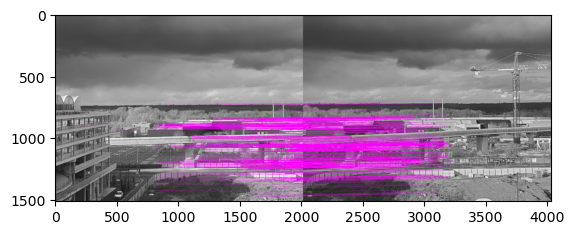

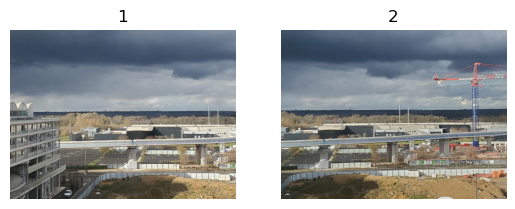

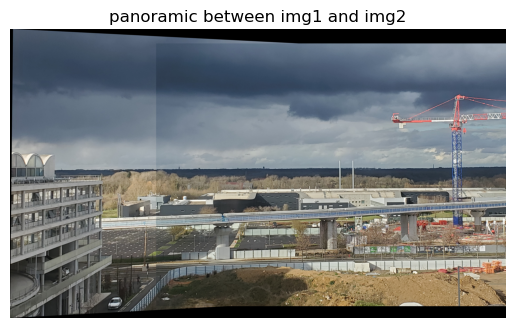

True

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Feb  2 13:49:38 2022

@author: roux
"""


import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow, show, subplot, title, axis, figure


# draw matches
def draw_matches(img1, kpt1, img2, kpt2, matches):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Create a blank image with the size of the first image + second image
    new_img = np.zeros((max([h1, h2]), w1 + w2, 3), dtype='uint8')
    new_img[:h1, :w1, :] = np.dstack([img1, img1, img1])
    new_img[:h2, w1:w1 + w2, :] = np.dstack([img2, img2, img2])

    # extract the match keypoints
    for m in matches:
        (x1, y1) = kpt1[m.queryIdx].pt
        (x2, y2) = kpt2[m.trainIdx].pt

        # Draw circles on the keypoints
        cv.circle(new_img, (int(x1), int(y1)), 4, (0, 255, 0), 1)
        cv.circle(new_img, (int(x2) + w1, int(y2)), 4, (0, 255, 0), 1)

        # Connect the same keypoints
        cv.line(new_img, (int(x1), int(y1)), (int(x2) + w1, int(y2)), (255, 0, 255), 1)

    return new_img


def warpImages(img1, img2, M):
    # get the corner coordinates of the "query" and "train" image
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    pts_corners_src = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    pts_corners_temp = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)

    # When we have established a homography we need to warp perspective
    # perform perspective tranform using previously calculated matrix and the corners of  
    #"query" image#
    # Change field of view
    pts_corners_dst = cv.perspectiveTransform(pts_corners_temp, M)

    ListOfPoints = np.concatenate((pts_corners_src, pts_corners_dst), axis=0)

    [x_min, y_min] = np.int32(ListOfPoints.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(ListOfPoints.max(axis=0).ravel() + 0.5)

    print(x_min,y_min,x_max,y_max)

    translation_dist = [-x_min, -y_min]

    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 
1]])

    new_img = cv.warpPerspective(img2, H_translation.dot(M), (x_max - x_min, y_max - y_min))
    new_img[translation_dist[1]:h1 + translation_dist[1], translation_dist[0]:w1 + translation_dist[0]] = img1

    return new_img



def find_homography(kpt1, kpt2, matches):
    # Find an Homography matrix between two pictures
    # Transforming keypoints to list of points
    src_pts = np.float32([kpt1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kpt2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Compute a rigid transformation (without depth, only scale + rotation + translation) /affine transformation
    transformation_rigid_matrix, mask = cv.estimateAffinePartial2D(src_pts, dst_pts)
    # transformation_rigid_matrix, mask = cv.estimateAffinePartial2D(src_pts, dst_pts)

    print(transformation_rigid_matrix)
    
    affine_row = [0, 0, 1]
    M= np.vstack((transformation_rigid_matrix, affine_row))
        
    M, mask = cv.findHomography(src_pts, dst_pts,cv.RANSAC,3)
    matchesMask = mask.ravel().tolist()
    print(M)
    
    #return transformation_rigid_matrix,matchesMask

    return M


outputName='panorama.tif'





img1c = cv.imread('palaiseau-B1sub.tif',1)
img2c = cv.imread('palaiseau-B2sub.tif',1)
#
#img2c = cv.imread('panorama.tif',1)
#img1c = cv.imread('palaiseau-B3sub.tif', 1)

img1 = cv.cvtColor(img1c, cv.COLOR_BGR2GRAY)
img2 = cv.cvtColor(img2c, cv.COLOR_BGR2GRAY)

img1c = cv.cvtColor(img1c, cv.COLOR_BGR2RGB)
img2c = cv.cvtColor(img2c, cv.COLOR_BGR2RGB)

# Initiate ORB detector, that it will be our detector object.
orb = cv.ORB_create(10000)


# find the keypoints and compute the descriptors with ORB for images
kpts1, des1 = orb.detectAndCompute(img1, None)
kpts2, des2 = orb.detectAndCompute(img2, None)


# Create a BFMatcher object.
bf = cv.BFMatcher_create(cv.NORM_HAMMING)

# match descriptor
matches1to2 = bf.knnMatch(des1, des2, k=2)


# draw matches
good1to2 = []
for m, n in matches1to2:
    if m.distance < 0.6 * n.distance:
        good1to2.append(m)

drawimg=draw_matches(img1, kpts1, img2, kpts2, good1to2)


# find  affine transformation and panoramic view between 1 to 2
matrix1to2 = find_homography(kpts1, kpts2, good1to2)
img1to2 = warpImages(img2c, img1c, matrix1to2)

figure()

imshow(drawimg)
show()


figure()

subplot(1, 2, 1)
imshow(img1c)
axis('off')
title('1')

subplot(1, 2, 2)
imshow(img2c)
axis('off')
title('2')

show()

figure()

title1 = "panoramic between img1 and img2"

subplot(1, 1, 1)
imshow(img1to2)
axis('off')
title(title1)

show()

img1to2 = cv.cvtColor(img1to2, cv.COLOR_BGR2RGB)
cv.imwrite(outputName,img1to2)





**Questions:**
1) Which geometrical transforma/on is pre-implemented? Is it appropriate for stitching? Why?


Try some other king of features rather than HOG. Choose among SIRF, SURF, HAZE, GLOH,...


2) What is the effect of a modification of the distance threshold?

1) The pre-implemented geometrical transformation is an affine transformation. It is appropriate for stitching because it can handle translation, rotation, and scaling, which are common in image stitching applications. However, it cannot handle non-linear distortions such as curvature, which may occur in certain stitching scenarios.
2) The distance threshold determines the threshold below which a match is considered a good match. A modification of this threshold affects the number of matches and their quality. Increasing the threshold leads to fewer matches but potentially better quality matches, while decreasing the threshold leads to more matches but potentially lower quality matches. Therefore, the appropriate distance threshold depends on the specific application and the desired trade-off between the number and quality of matches.

**Corners.py** :

 **Questions**: 

1) What is the purpose of the Gaussian blur?


We use this Gaussian filter because of the Canny filter we want to use to do corner detection. The purpose of applying a Gaussian blur before applying a Canny filter is to reduce the noise (it can create false edges in the Canny filter) and smooth out the image, which can create false edges in the image. By applying a Gaussian blur before the Canny filter, the noise is reduced and the edges become clearer and easier to detect.

2)  What other filtering could have been more appropriate?


We can think of different other filtering: 
For instance, we can use a median filter: Median Filter: it is particularly effective at removing salt-and-pepper noise, which is present on the image we are analysing. This type of noise can be a problem for edge detection because it can produce false edges.  
  
Another technique that we can think of is the Wiener Filter: it is particularly effective for Gaussian noise, making it a good choice if the noise in the image is Gaussian.

3) Give a short description of the main elements and analyse the effects of the different parameters (Canny, Hough,...)


First, the image is converted to grayscale to simplify the processing. Then, a Gaussian blur is applied to reduce noise in the image: this is what we explained at the previous question. Next, edges are detected using the Canny edge detector. Finally, the Hough transform is used to detect straight lines in the edge image, from the Canny edges.

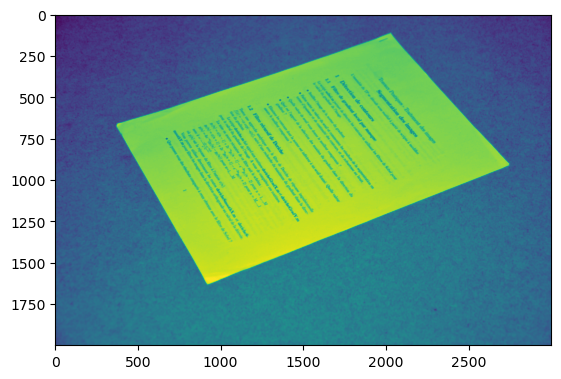

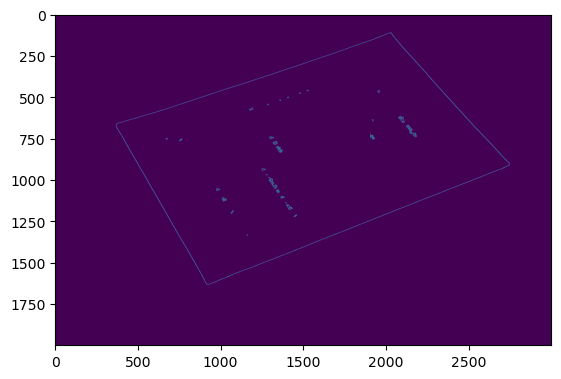

nombre de lignes :  [[[ 1.9000000e+01  2.6179938e+00]]

 [[-1.4290000e+03  2.4085543e+00]]

 [[ 7.5100000e+02  1.2566371e+00]]

 [[ 1.8670000e+03  1.1868238e+00]]

 [[ 1.8700000e+03  1.1868238e+00]]

 [[-1.3530000e+03  2.3736477e+00]]

 [[ 1.8760000e+03  1.1868238e+00]]

 [[ 7.3800000e+02  1.2915436e+00]]

 [[ 7.9900000e+02  1.2217305e+00]]

 [[ 1.8620000e+03  1.1868238e+00]]

 [[ 7.4700000e+02  1.2566371e+00]]

 [[-1.4820000e+03  2.4434609e+00]]

 [[-1.4360000e+03  2.4085543e+00]]

 [[ 1.8740000e+03  1.1868238e+00]]]
nombre de lignes :  14
19.0 2.6179938
-1429.0 2.4085543
751.0 1.2566371
1867.0 1.1868238
1870.0 1.1868238
-1353.0 2.3736477
1876.0 1.1868238
738.0 1.2915436
799.0 1.2217305
1862.0 1.1868238
747.0 1.2566371
-1482.0 2.443461
-1436.0 2.4085543
1874.0 1.1868238
365 670
2037 127
924 1639
2739 906
926 1642
2741 909
2502 643
2012 135
2751 901
2754 904
929 1647
2745 913
2758 908
361 664
2077 171
573 603
2053 178
387 709
2024 113
1552 285
1999 122
1068 461
922 1635
2735 902
2748 8

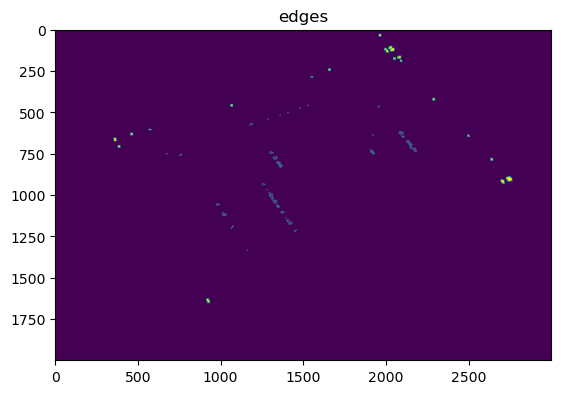

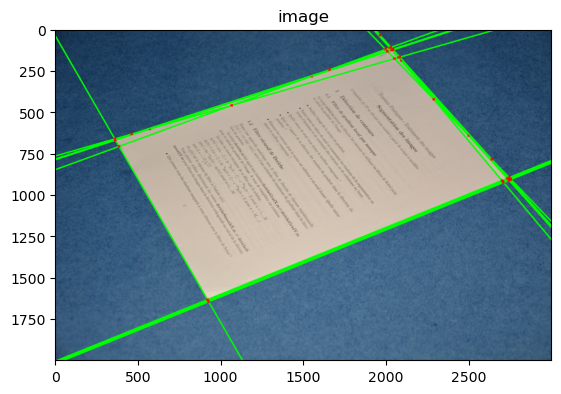

True

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Feb  6 21:06:13 2022

@author: roux
"""


import cv2 
import numpy as np 
import matplotlib.pyplot as plt

img = cv2.imread('f7.tif') 
imrvb=img.copy()


gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)     

kernel = np.ones((9,9),np.uint8)
#gray = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)

gray = cv2.GaussianBlur(gray,(9,9),0)

#gray = cv2.medianBlur(gray, ksize=13)

plt.figure()
plt.imshow(gray)
plt.show()
  
edges = cv2.Canny(gray,20,180,apertureSize =3) 
  

  
plt.figure('Canny edges')
plt.imshow(edges)
plt.show()

    
lines = cv2.HoughLines(edges,1,2*np.pi/180,100) 

nbrlines = lines.shape[0]

print('nombre de lignes : ', lines)

print('nombre de lignes : ', nbrlines)


for line1 in range(nbrlines):  
    r1,theta1 = lines[line1][0]
    print(r1,theta1)

nbrintersects=0

fichier = open("data.txt", "w")

for line1 in range(nbrlines):  
    r1,theta1 = lines[line1][0]
    
    a1 = np.cos(theta1) 
    b1 = np.sin(theta1)
    c1 = -r1
    
    x1 = int(a1*r1 + 4000*(-b1)) 
    y1 = int(b1*r1 + 4000*(a1)) 
    x2 = int(a1*r1 - 4000*(-b1)) 
    y2 = int(b1*r1 - 4000*(a1)) 
          
    (a,b,c)=125+125*np.random.rand(3, 1)
    a=int(0)
    b=int(255)
    c=int(0)
    cv2.line(imrvb,(x1,y1), (x2,y2), (a,b,c),7) 
    cv2.line(edges,(x1,y1), (x2,y2), (a,b,c),7) 
    
    x1=int(a1+5)
    y1=int(b1+5)
    x2=int(a1-5)
    y2=int(b1-5)
    
    a=255
    b=0
    c=0
    
    cv2.line(imrvb,(x1,y1), (x2,y2), (a,b,c),5) 
    cv2.line(edges,(x1,y1), (x2,y2), (a,b,c),5) 
#
#    plt.figure()
#    plt.title('edges hough')
#    plt.imshow(edges)
#    plt.show()
#
#    plt.figure()
#    plt.title('image hough')
#    plt.imshow(imrvb)
#    plt.show()


    for line2 in range(line1):
        
        r2,theta2 = lines[line2][0]

        a2 = np.cos(theta2) 
        b2 = np.sin(theta2)
        c2 = -r2
    
        
        X =   b1 * c2 - c1 * b2
        Y =   c1 * a2 - a1 * c2
        Z =   a1 * b2 - b1 * a2
        

        if Z != 0:
            
            X=X/Z
            Y=Y/Z   
            
            if 0 < X < img.shape[1]:
                if 0 < Y < img.shape[0]:
                                
                    nbrintersects += 1
                    
                    print(int(X),int(Y))
                    
                    fichier.write(str ( int ( X ) ) )
                    fichier.write (" ")
                    fichier.write(str ( int ( Y ) ) ) 
                    fichier.write("\n")
                    
                    x1=int(X+5)
                    y1=int(Y+5)
                    x2=int(X-5)
                    y2=int(Y-5)
                
                    a=255
                    b=0
                    c=0
                
                    cv2.line(imrvb,(x1,y1), (x2,y2), (a,b,c),5) 
                    cv2.line(edges,(x1,y1), (x2,y2), (a,b,c),5) 
        
                    x1=int(X-5)
                    y1=int(Y+5)
                    x2=int(X+5)
                    y2=int(Y-5)
        
                    cv2.line(imrvb,(x1,y1), (x2,y2), (a,b,c),5) 
                    cv2.line(edges,(x1,y1), (x2,y2), (a,b,c),5) 

fichier.close()


print('nbr intersects',nbrintersects)

plt.figure()
plt.title('edges')
plt.imshow(edges)
plt.show()

plt.figure()
plt.title('image')
plt.imshow(imrvb)
plt.show()



cv2.imwrite('linesDetected.jpg', img) 

**Questions**:
1) The purpose of this script is to detect corner in the image, which is useful for many 
applications that need the matching of points.  
2) What is the purpose of the Gaussian blur? 
3) What other filtering could have been more appropriate? 
4) Give a short description of the main elements and analyse the effects of the different 
parameters (Canny, Hough,...)

**RedresA4.py**:


In [8]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow, show, subplot, title, axis, figure, plot


# draw matches
def draw_matches(img2, kpt2, matches,rayon):

    h2, w2 = img2.shape[:2]

    # Create a blank image with the size of the first image + second image
    new_img = np.zeros((h2, w2, 3), dtype='uint8')
#    new_img[:h2, :w2, :] = np.dstack([img2, img2, img2])
    new_img[:h2, :w2, :] = np.dstack([img2])

    # extract the match keypoints
    
    for m in matches:
        (x2, y2) = kpt2[m.trainIdx].pt

        # Draw circles on the keypoints
        cv.circle(new_img, (int(x2), int(y2)), rayon, (255, 255, 255), 1)

    return new_img


def warpImages(kp, img, M):
    # get the corner coordinates of the "query" and "train" image
    h, w = img.shape[:2]

    new_img = cv.warpPerspective(img, M, (w, h))

    return new_img


def find_homography(kpt1, kpt2, matches):
    # Find an Homography matrix between two pictures
    # Transforming keypoints to list of points
   
    dst_pts = np.float32([kpt1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    src_pts = np.float32([kpt2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
 
    # Compute an homography
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 3)

    return M


# Read images
img1c = cv.imread('f7.jpg', 1)
img1 = cv.cvtColor(img1c, cv.COLOR_BGR2GRAY)
img1c = cv.cvtColor(img1c, cv.COLOR_BGR2RGB)

# Load points from file
pts1 = []
with open('data.txt', 'r') as f:
    for line in f:
        x, y = line.split()
        pts1.append([int(x), int(y)])

# Define the point correspondences for the second image
x1 = 2030
y1 = 110
x2 = 2750
y2 = 904
x3 = 920
y3 = 1638
x4 = 363
y4 = 663

pts2 = [[x1, y1], [x2, y2], [x3, y3], [x4, y4]]

kp1 = [cv.KeyPoint(x[0], x[1], 1) for x in pts1]
kp2 = [cv.KeyPoint(x[0], x[1], 1) for x in pts2]

goodMatches = []
for i in range(len(pts1)):
    m = cv.DMatch(i, i, 0)
    goodMatches.append(m)

matrix1to2 = find_homography(kp1, kp2, goodMatches)
img1to2 = warpImages(kp1, img1c, matrix1to2)

figure()


kp_img = cv.drawKeypoints(img1, kp2, None, color=(0, 255, 0))


imshow(kp_img)
show()


#
## find  affine transformation and panoramic view between 1 to 2
matrix1to2 = find_homography(kp1, kp2,goodMatches)
img1to2 = warpImages(kp1,img1c, matrix1to2)
#

figure()

imshow(img1to2)
show()

IndexError: list index out of range

**Questions** :
1) Apply this script to the image of a building 
2) Test the robustness by adding some outliers 
3) Replace the manually selected points with the output of corners.py. Comment 

**Answers**:

2) We notice that when we add more outliers, it has a negative impact on the accuracy of the homography estimation. Indeed, outliers are data points that do not follow the pattern of the majority of the data, and they can cause the estimation algorithm to produce incorrect results. The more outliers there are, the greater the chances of the algorithm being misled by these points and producing an incorrect homography matrix. As a result, the quality of the panoramic view suffer, and it does not accurately align the images as desired. Therefore, we conclude it is important to limit the number of outliers and ensure that they are properly handled during the estimation process.
3) 